In [1]:
pip install xgboost lightgbm catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 MB 8.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 49.2 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 17.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 16.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [9]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import optuna as op

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

train['Time'] = train['Time'] / 3600
test['Time'] = test['Time'] / 3600

train = train[(train['Time'] >= 10) & (train['Time'] <= 24)].reset_index(drop = True)

In [7]:
train['Time'].describe()

count    164306.000000
mean         17.496895
std           3.730481
min          10.002500
25%          14.574167
50%          17.638333
75%          20.675833
max          24.000000
Name: Time, dtype: float64

# Feature From Kaggle

In [13]:
train['V20_div_Amount'] = train.V20 / train.Amount
train['V23_div_Amount'] = train.V23 / train.Amount
train['V27_div_28'] = train.V27 / train.V28
# train['V20_div_Amount_div_V27_div_28'] = train['V20_div_Amount'] / train['V27_div_28']
# train['V23_div_Amount_div_V27_div_28'] = train['V23_div_Amount'] / train['V27_div_28']

test['V20_div_Amount'] = test.V20 / test.Amount
test['V23_div_Amount'] = test.V23 / test.Amount
test['V27_div_28'] = test.V27 / test.V28
# test['V20_div_Amount_div_V27_div_28'] = test['V20_div_Amount'] / test['V27_div_28']
# test['V23_div_Amount_div_V27_div_28'] = test['V23_div_Amount'] / test['V27_div_28']

In [79]:
test.head()

id      Time        V1        V2        V3        V4        V5  \
0  219129  120580.0  2.115519 -0.691809 -1.305514 -0.685655 -0.641265   
1  219130  120580.0  1.743525 -1.681429 -0.547387 -1.061113 -0.695825   
2  219131  120580.0  2.205568 -1.571445 -0.238965 -1.662517 -1.652324   
3  219132  120580.0  1.989728 -0.972909 -1.938259 -1.440129 -0.166855   
4  219133  120580.0 -1.943548 -1.668761  0.363601 -0.977610  2.684779   

         V6        V7        V8        V9       V10       V11       V12  \
0 -0.764784 -0.924262 -0.023030 -0.230126  0.220610  1.058325 -0.723363   
1  2.458824 -1.632859  1.073529  1.068183  0.483337  0.274519 -0.346514   
2 -0.054701 -1.682064  0.105613 -1.177858  1.626352  0.601148 -0.041610   
3 -0.794048  0.252889 -0.399789  2.079398 -1.225592 -0.869368  1.647638   
4 -2.037681  0.039709 -0.048895 -0.281749 -0.341879  0.471628  0.637604   

        V13       V14       V15       V16       V17       V18       V19  \
0 -0.619241 -2.243711 -0.271429  2.007845  1.213534  0.282344  0.579121   
1 -0.409519 -0.564673 -0.143855  1.334855  0.160901 -0.087356 -0.066264   
2  0.432748 -0.527684 -0.543665  0.043896  0.058472  0.622667  0.010671   
3  1.138026 -0.258468 -0.361765 -1.253326  0.099479 -0.587702  1.207085   
4 -0.592416  0.331702 -1.451799  0.096467 -0.853439 -0.462060 -0.267098   

        V20       V21       V22       V23       V24       V25       V26  \
0  0.067367  0.241708  0.682524  0.037769 -0.546859 -0.123055 -0.084889   
1  0.441788  0.543278  1.294571  0.309541  3.703925 -0.242579  0.068708   
2 -0.366906 -0.131527  0.086623  0.291375  0.739087 -0.543006 -0.297813   
3 -0.049136 -0.080115 -0.010732 -0.038550  0.656830  0.343470 -0.627529   
4  0.391627  0.083389 -0.306918  0.247822 -0.391799 -0.790716 -0.025706   

        V27       V28  Amount  
0  0.004720 -0.021944   29.95  
1  0.002629  0.064690  163.50  
2  0.043699 -0.037855   16.00  
3 -0.024338 -0.036143  120.98  
4  0.330758  0.335537    1.98

In [51]:
train.head()

id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.110697 -0.263477  0.742144  0.108782 -1.070243 -0.234910 -1.099360   
1 -1.029289  0.050198 -0.109948  0.908773  0.836798 -0.056580 -0.120990   
2  0.948146 -0.084789 -0.042027 -0.818383 -0.376512 -0.226546 -0.552869   
3 -0.087826 -0.035367  0.885838 -0.007527  0.637441  0.676960 -1.504823   
4 -0.938651  0.569239  0.692665 -0.097495  1.338869  1.391399 -0.128167   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.502467  0.169318  0.065688 -0.306957 -0.323800  0.103348 -0.292969   
1 -0.144028 -0.039582  1.653057 -0.253599 -0.814354  0.716784  0.065717   
2 -0.886466 -0.180890  0.230286  0.590579 -0.321590 -0.433959 -0.021375   
3  0.554039 -0.824356 -0.527267 -0.095838 -0.312519  0.642659 -0.340089   
4 -0.081836  0.100548 -0.338937  0.090864 -0.423645 -0.731939 -0.203628   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.334701 -0.887840  0.336701 -0.110835 -0.291459  0.207733 -0.076576   
1  0.054848 -0.038367  0.133518 -0.461928 -0.465491 -0.464655 -0.009413   
2 -0.326725 -0.803736  0.154495  0.951233 -0.506919  0.085046  0.224458   
3 -0.095514 -0.079792  0.167701 -0.042939  0.000799 -0.096148 -0.057780   
4  0.099157  0.608908  0.027901 -0.262813  0.257834 -0.252829  0.108338   

        V28  Amount  Class  
0 -0.059577    1.98      0  
1 -0.038238   84.00      0  
2  0.087356    2.69      0  
3 -0.073839    1.00      0  
4  0.021051    1.00      0

# Data Exploration

In [16]:
train.head()

id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.110697 -0.263477  0.742144  0.108782 -1.070243 -0.234910 -1.099360   
1 -1.029289  0.050198 -0.109948  0.908773  0.836798 -0.056580 -0.120990   
2  0.948146 -0.084789 -0.042027 -0.818383 -0.376512 -0.226546 -0.552869   
3 -0.087826 -0.035367  0.885838 -0.007527  0.637441  0.676960 -1.504823   
4 -0.938651  0.569239  0.692665 -0.097495  1.338869  1.391399 -0.128167   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.502467  0.169318  0.065688 -0.306957 -0.323800  0.103348 -0.292969   
1 -0.144028 -0.039582  1.653057 -0.253599 -0.814354  0.716784  0.065717   
2 -0.886466 -0.180890  0.230286  0.590579 -0.321590 -0.433959 -0.021375   
3  0.554039 -0.824356 -0.527267 -0.095838 -0.312519  0.642659 -0.340089   
4 -0.081836  0.100548 -0.338937  0.090864 -0.423645 -0.731939 -0.203628   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.334701 -0.887840  0.336701 -0.110835 -0.291459  0.207733 -0.076576   
1  0.054848 -0.038367  0.133518 -0.461928 -0.465491 -0.464655 -0.009413   
2 -0.326725 -0.803736  0.154495  0.951233 -0.506919  0.085046  0.224458   
3 -0.095514 -0.079792  0.167701 -0.042939  0.000799 -0.096148 -0.057780   
4  0.099157  0.608908  0.027901 -0.262813  0.257834 -0.252829  0.108338   

        V28  Amount  Class  
0 -0.059577    1.98      0  
1 -0.038238   84.00      0  
2  0.087356    2.69      0  
3 -0.073839    1.00      0  
4  0.021051    1.00      0

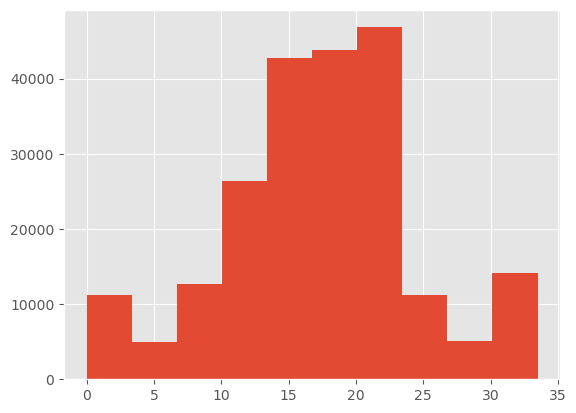

In [57]:
train['Time'] = train['Time'] / 3600
train['Time'].hist();

In [60]:
train['Time_Label'] = np.where(((train['Time'] >= 0) & (train['Time'] < 4)), 'Early_Morning',
                               np.where(((train['Time'] >= 4) & (train['Time'] < 10)), 'Morning',
                                       np.where(((train['Time'] >= 10) & (train['Time'] < 16)), 'Afternoon',
                                                np.where(((train['Time'] >= 16) & (train['Time'] < 22)), 'Night',
                                                         np.where(((train['Time'] >= 22) & (train['Time'] < 28)), 'Early_Morning', 'Morning')))))

In [64]:
test['Time_Label'] = np.where(((test['Time'] >= 33) & (test['Time'] < 34)), 'Morning', 
                              np.where(((test['Time'] >= 34) & (test['Time'] < 40)), 'Afternoon', 
                                       np.where(((test['Time'] >= 40) & (test['Time'] < 46)), 'Night', 'Eraly_Morning')))

In [61]:
train['Time_Label'].value_counts()

Night            81738
Afternoon        60465
Early_Morning    43238
Morning          33688
Name: Time_Label, dtype: int64

In [58]:
train['Time'].describe()

count    219129.000000
mean         17.327060
std           7.116763
min           0.000000
25%          13.314722
50%          17.552500
75%          21.533056
max          33.494444
Name: Time, dtype: float64

In [63]:
test['Time'] = test['Time'] / 3600
test['Time'].describe()

count    146087.000000
mean         40.177202
std           3.960563
min          33.494444
25%          36.860556
50%          40.136944
75%          43.372222
max          47.997222
Name: Time, dtype: float64

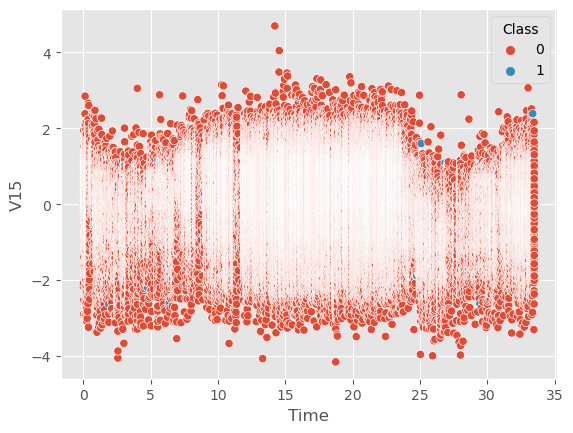

In [18]:
sns.scatterplot(x = 'Time', y = 'V15', data = train, hue = 'Class');

In [22]:
data_temp = train[train['Class'] == 1].reset_index(drop = True)

data_temp.head(10)

# plt.plot('Time', data = data_temp)
# plt.show();

id      Time        V1        V2        V3        V4        V5        V6  \
0  1681  0.212222  0.845797 -1.063059  0.120133 -0.312570 -0.056194  1.944391   
1  2039  0.256389 -1.808089  1.794735 -2.574549 -1.944174 -4.093440 -1.360198   
2  2090  0.285556 -0.368027  1.492913  0.653399  0.164478 -1.043918  0.766250   
3  3072  0.368889  1.990241 -0.185837 -1.039174  0.086245  0.107037 -0.409425   
4  3780  0.399444 -0.738582  0.654464  0.652465 -0.139933  1.183689 -0.037131   
5  4473  0.434722 -0.052488  0.452235  0.597834 -1.036066  0.634370 -0.003599   
6  5136  0.476944  0.160589  0.786825 -0.724588 -0.750282  1.806480  0.934250   
7  5154  0.477500 -3.926970  1.591747 -3.651351  5.717551  3.759827 -2.266875   
8  5699  0.845833 -0.760997  0.756909 -0.178814 -3.217133  2.647633  2.961634   
9  5733  0.860556 -1.127728  1.049167 -1.053558 -3.509578  0.446634  2.913674   

         V7        V8        V9       V10       V11       V12       V13  \
0 -0.661839  0.582721 -0.992366  0.564202  1.766655  0.826499 -0.307964   
1 -8.837694 -3.865127  4.847707 -1.826233 -1.552959  1.796523 -1.531125   
2 -2.717382 -6.944203 -0.938474 -1.243744  1.555025  2.133379  0.125978   
3  0.016713 -0.126446  0.279865  0.184726  1.090518  1.617814  0.906706   
4  0.638169  0.136502 -0.357541 -0.238928  1.039441  0.302428 -1.116929   
5  0.423917 -0.061588  0.004540 -0.528083 -1.837332 -0.264823  0.893536   
6  0.813886  0.023870  0.212364 -0.903241  0.974441  0.624075  0.116702   
7  0.726805 -2.907956 -2.341475 -1.335848  2.906954 -2.067952 -0.452826   
8  0.673867  0.570116  0.876679 -0.867483 -0.213593  0.141608 -0.310089   
9  1.004565 -1.852860 -0.099877 -2.039180 -0.104640  0.146959 -0.813447   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.393909  0.907691 -2.822682  1.055578 -1.061441 -2.138524 -0.569641   
1 -0.242458  0.926706  0.113577 -0.155949  0.393524  1.085312  1.570826   
2  1.131705  0.057716  0.944642 -0.440088  0.049590 -0.878509  1.180116   
3  0.254738 -0.673049  0.193427 -0.771428 -0.214947  0.468155 -0.094906   
4  0.651270 -0.295048 -0.421716 -0.456629 -0.037795 -0.826278 -0.314816   
5 -0.006498  0.722872  1.132529 -1.366899  0.265849  0.428969  0.016501   
6 -1.391239 -0.394833 -0.637392  0.938174 -0.456530 -1.069392 -0.098123   
7 -6.569330  0.934333  1.571465  5.496659  2.558977 -0.281809 -0.738004   
8  0.079070  0.633451 -0.120985 -1.182215  0.359537  0.270846  0.013869   
9  0.976078  1.096701  0.008673 -0.845663  0.221515  0.074959  0.143465   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.430906 -0.919078  0.123612 -1.420935 -0.072559  0.293439  0.061270   
1 -2.662635  1.173416 -0.136751  0.739760 -0.692745  0.818293  0.745100   
2 -0.058687  1.185031  0.290564  0.528459  0.764303 -0.017768  0.110884   
3 -0.142725 -0.285513  0.263769  0.779628 -0.261358  0.255895 -0.074999   
4  0.167918  0.563421  0.012614 -0.311213  0.105798 -0.252849  0.049231   
5 -0.154343 -0.453740 -0.176718 -1.347568 -0.474435  0.834288 -0.074879   
6  0.221559  1.074745 -0.077353 -1.746858 -0.965505 -0.109738 -0.096479   
7  2.203823 -0.938597 -1.534221 -0.433038 -0.324845  0.409565  1.251167   
8 -0.019683  0.173905 -0.310044  0.998894  0.204869 -0.817079  0.285749   
9 -1.347635  1.078594  0.097118  0.932598  0.102219 -0.890189  0.356712   

        V28  Amount  Class  
0  0.006448  136.58      1  
1  0.847648    2.00      1  
2  0.307835    0.12      1  
3 -0.059828   23.31      1  
4  0.108966    4.99      1  
5 -0.023830    1.00      1  
6 -0.207858    5.80      1  
7 -0.926380    0.77      1  
8  0.068652    1.00      1  
9 -0.104950  324.15      1

In [23]:
data_temp.describe()

id        Time          V1          V2          V3  \
count     469.000000  469.000000  469.000000  469.000000  469.000000   
mean   121243.722814   18.385665   -1.086640    0.360162   -0.729018   
std     67374.938718    7.715779    3.202974    4.255666    2.759541   
min      1681.000000    0.212222  -23.735245  -44.247914  -19.088980   
25%     63361.000000   14.140833   -1.827097   -0.219947   -1.679817   
50%    131980.000000   19.249167   -0.597535    0.588968   -0.251228   
75%    183572.000000   22.934167    1.122965    1.637133    0.888828   
max    219086.000000   33.492500    2.169813    9.275076    3.697068   

               V4          V5          V6          V7          V8          V9  \
count  469.000000  469.000000  469.000000  469.000000  469.000000  469.000000   
mean     0.826276    0.072711    0.024195   -0.562112   -0.434633    0.295541   
std      1.786987    2.164791    1.821944    2.465869    2.397392    1.695613   
min     -4.044858  -16.143833  -16.357833  -21.876190  -17.374875   -8.756951   
25%     -0.104799   -0.784489   -0.907924   -0.918130   -0.359011   -0.615825   
50%      0.812230    0.015662   -0.124916   -0.269415    0.022567    0.028653   
75%      1.505569    0.858477    0.664157    0.376847    0.446651    1.012628   
max      8.918977   20.976643    7.363600   15.923791   14.073865   10.408025   

              V10         V11         V12         V13         V14         V15  \
count  469.000000  469.000000  469.000000  469.000000  469.000000  469.000000   
mean    -0.330673    0.501366   -0.500703    0.104337   -0.596737    0.215408   
std      2.238858    1.369314    1.954465    1.171571    2.177261    1.008562   
min    -11.078394   -3.116825  -12.811547   -3.547486  -13.711105   -2.745817   
25%     -1.146427   -0.438034   -1.124716   -0.692927   -1.121400   -0.394833   
50%     -0.369917    0.420047   -0.010684    0.011366   -0.084579    0.372802   
75%      0.146439    1.283389    0.634221    0.884935    0.602488    0.945750   
max     11.663813    6.304578    5.406614    3.664370    3.917690    2.796549   

              V16         V17         V18         V19         V20         V21  \
count  469.000000  469.000000  469.000000  469.000000  469.000000  469.000000   
mean    -0.077345    0.231121    0.322761   -0.158610    0.181932    0.032385   
std      1.480743    2.391667    1.175975    0.968297    1.540108    1.259590   
min    -10.781414  -18.109933   -7.456060   -3.658399  -12.751490   -6.567663   
25%     -0.617817   -0.404518   -0.166940   -0.801085   -0.204949   -0.246089   
50%      0.122675    0.147059    0.331469   -0.202624   -0.042728   -0.034481   
75%      0.737569    1.001344    0.992751    0.426517    0.244513    0.187923   
max      5.834992    6.138931    2.933991    4.031429   13.585749    8.097728   

              V22         V23         V24         V25         V26         V27  \
count  469.000000  469.000000  469.000000  469.000000  469.000000  469.000000   
mean    -0.030467   -0.125792   -0.071228    0.118310   -0.147291   -0.001152   
std      0.804570    1.125668    0.644059    0.589565    0.463175    0.748919   
min     -5.109636   -8.895803   -1.857683   -3.958591   -1.343868   -9.234767   
25%     -0.480110   -0.217749   -0.439481   -0.228727   -0.418924   -0.041335   
50%     -0.009526   -0.046046   -0.041213    0.116638   -0.252230    0.036790   
75%      0.490126    0.110160    0.385332    0.486712    0.092445    0.132959   
max      3.066008    5.312675    1.135796    2.420944    2.658908    1.967485   

              V28       Amount  Class  
count  469.000000   469.000000  469.0  
mean     0.085422   108.391002    1.0  
std      1.168934   376.603036    0.0  
min     -3.310876     0.000000    1.0  
25%     -0.044723     1.000000    1.0  
50%      0.027947     8.760000    1.0  
75%      0.131848    39.950000    1.0  
max     23.263746  4471.960000    1.0

In [24]:
train.shape

(219129, 32)

In [25]:
test.shape

(146087, 31)

In [26]:
146087 / 219129

0.6666712301886104

In [31]:
data_temp.head()

id      Time        V1        V2        V3        V4        V5        V6  \
0  1681  0.212222  0.845797 -1.063059  0.120133 -0.312570 -0.056194  1.944391   
1  2039  0.256389 -1.808089  1.794735 -2.574549 -1.944174 -4.093440 -1.360198   
2  2090  0.285556 -0.368027  1.492913  0.653399  0.164478 -1.043918  0.766250   
3  3072  0.368889  1.990241 -0.185837 -1.039174  0.086245  0.107037 -0.409425   
4  3780  0.399444 -0.738582  0.654464  0.652465 -0.139933  1.183689 -0.037131   

         V7        V8        V9       V10       V11       V12       V13  \
0 -0.661839  0.582721 -0.992366  0.564202  1.766655  0.826499 -0.307964   
1 -8.837694 -3.865127  4.847707 -1.826233 -1.552959  1.796523 -1.531125   
2 -2.717382 -6.944203 -0.938474 -1.243744  1.555025  2.133379  0.125978   
3  0.016713 -0.126446  0.279865  0.184726  1.090518  1.617814  0.906706   
4  0.638169  0.136502 -0.357541 -0.238928  1.039441  0.302428 -1.116929   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.393909  0.907691 -2.822682  1.055578 -1.061441 -2.138524 -0.569641   
1 -0.242458  0.926706  0.113577 -0.155949  0.393524  1.085312  1.570826   
2  1.131705  0.057716  0.944642 -0.440088  0.049590 -0.878509  1.180116   
3  0.254738 -0.673049  0.193427 -0.771428 -0.214947  0.468155 -0.094906   
4  0.651270 -0.295048 -0.421716 -0.456629 -0.037795 -0.826278 -0.314816   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.430906 -0.919078  0.123612 -1.420935 -0.072559  0.293439  0.061270   
1 -2.662635  1.173416 -0.136751  0.739760 -0.692745  0.818293  0.745100   
2 -0.058687  1.185031  0.290564  0.528459  0.764303 -0.017768  0.110884   
3 -0.142725 -0.285513  0.263769  0.779628 -0.261358  0.255895 -0.074999   
4  0.167918  0.563421  0.012614 -0.311213  0.105798 -0.252849  0.049231   

        V28  Amount  Class  
0  0.006448  136.58      1  
1  0.847648    2.00      1  
2  0.307835    0.12      1  
3 -0.059828   23.31      1  
4  0.108966    4.99      1

<AxesSubplot: >

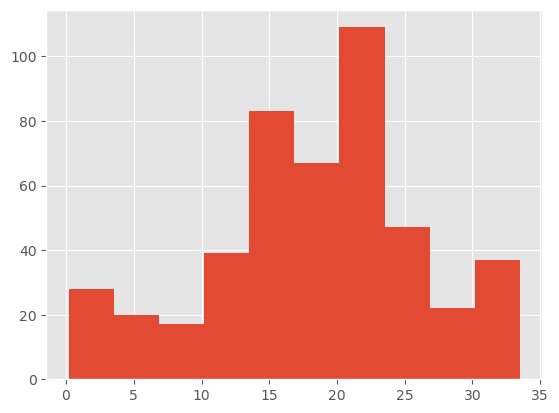

In [37]:
data_temp['Time'].hist()

In [38]:
data_temp['Time'].describe()

count    469.000000
mean      18.385665
std        7.715779
min        0.212222
25%       14.140833
50%       19.249167
75%       22.934167
max       33.492500
Name: Time, dtype: float64

# Looking at the first 6 hours 

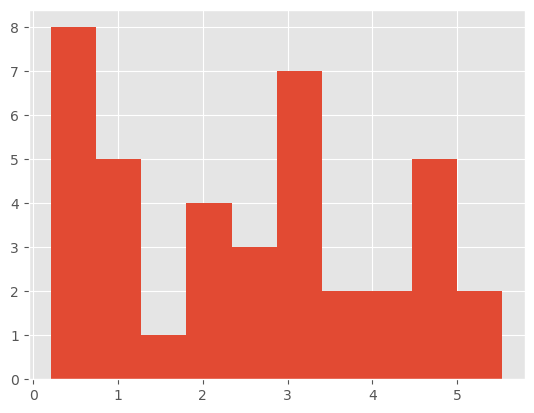

In [41]:
data_6 = train[train['Time'] < 6]
data_6_fraud = data_6[data_6['Class'] == 1]
data_6_fraud['Time'].hist();

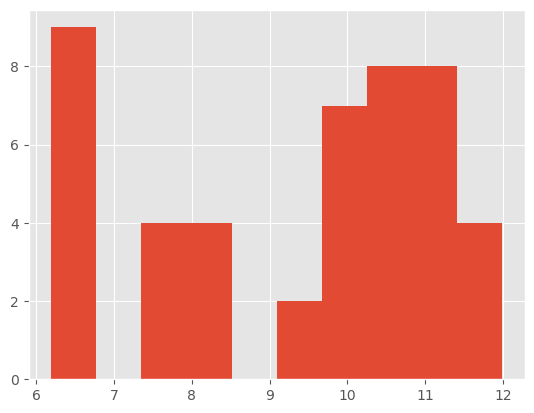

In [42]:
data_12 = train[(train['Time'] > 6) & (train['Time'] < 12)]
data_12_fraud = data_12[data_12['Class'] == 1]
data_12_fraud['Time'].hist();

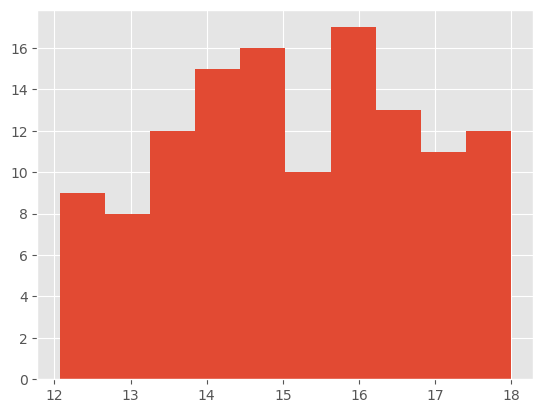

In [43]:
data_18 = train[(train['Time'] > 12) & (train['Time'] < 18)]
data_18_fraud = data_18[data_18['Class'] == 1]
data_18_fraud['Time'].hist();

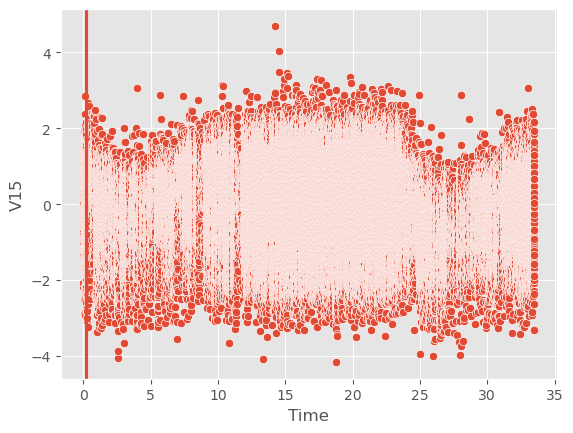

In [34]:
sns.scatterplot(x = 'Time', y = 'V15', data = train);
plt.axvline(x = 0.212222);
plt.axvline(x = 0.256389);
plt.axvline(x = 0.285556);

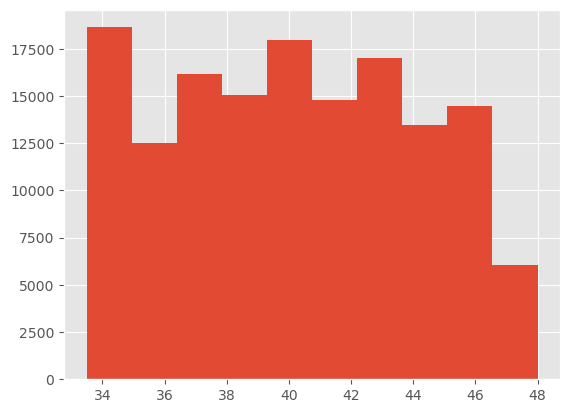

In [19]:
test['Time'] = test['Time'] / 3600
test['Time'].hist();

# XGBoost Modeling

In [12]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
# test = test.drop(columns = 'id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, shuffle = False)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 1000, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8149574595948108


In [13]:
XGB_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)
submission['Class'] = XGB_preds_test
submission.to_csv('xgb_submission_1.csv', index = False)

# LightGBM Modeling

In [80]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
test = test.drop(columns = 'id', axis = 1)

In [83]:
scaler = MinMaxScaler()

lgb_cv_scores, lgb_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
#         X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 10,
                                lambda_l1 = 0.66635,
                                lambda_l2 = 0.00011,
                                bagging_fraction = 0.77,
                                feature_fraction = 0.67,
                                bagging_freq = 6).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        lgb_cv_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=0.66635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.66635
[LightGBM] [Warning] feature_fraction is set=0.67, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011
[LightGBM] [Warning] bagging_fraction is set=0.77, subsample=1.0 will be ignored. Current value: bagging_fraction=0.77
[LightGBM] [Warning] lambda_l1 is set=0.66635, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.66635
[LightGBM] [Warning] feature_fraction is set=0.67, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.67
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011, reg_lambda=0.0 will be ignored. 

In [84]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = lgb_preds_test
submission.to_csv('lgb_submission_1.csv', index = False)

# CatBoost

In [19]:
cat_cv_scores, cat_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
        X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building the CatBoost model
        cat_md = CatBoostClassifier(iterations = 1000, 
                                    depth = 7,
                                    learning_rate = 0.01,
                                    rsm = 0.5,
                                    subsample = 0.9,
                                    l2_leaf_reg = 69,
                                    min_data_in_leaf = 20,
                                    random_strength = 0.175,
                                    random_seed = 836,
                                    task_type = 'CPU',
                                    bootstrap_type = 'Bernoulli',
                                    grow_policy = 'SymmetricTree',
                                    loss_function = 'Logloss',
                                    verbose = False).fit(X_train, Y_train)
        cat_imp.append(cat_md.feature_importances_)
            
        ## Predicting on X_test and test
        cat_pred_1 = cat_md.predict_proba(X_test)[:, 1]
        cat_pred_2 = cat_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        cat_cv_scores.append(roc_auc_score(Y_test, cat_pred_1))
        preds.append(cat_pred_2)
        
cat_cv_score = np.mean(cat_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', cat_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.7477153684335462


In [ ]:
cat_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = cat_preds_test
submission.to_csv('CatBoost_submission.csv', index = False)

# Adding Time Feature

In [29]:
train['Time'] = train['Time'] / 3600
test['Time'] = test['Time'] / 3600

train['Time_Label'] = np.where(((train['Time'] >= 0) & (train['Time'] < 4)), 'Early_Morning',
                               np.where(((train['Time'] >= 4) & (train['Time'] < 10)), 'Morning',
                                       np.where(((train['Time'] >= 10) & (train['Time'] < 16)), 'Afternoon',
                                                np.where(((train['Time'] >= 16) & (train['Time'] < 22)), 'Night',
                                                         np.where(((train['Time'] >= 22) & (train['Time'] < 28)), 'Early_Morning', 'Morning')))))

test['Time_Label'] = np.where(((test['Time'] >= 33) & (test['Time'] < 34)), 'Morning', 
                              np.where(((test['Time'] >= 34) & (test['Time'] < 40)), 'Afternoon', 
                                       np.where(((test['Time'] >= 40) & (test['Time'] < 46)), 'Night', 'Early_Morning')))

train_dummies = pd.get_dummies(train['Time_Label'])
test_dummies = pd.get_dummies(test['Time_Label'])

train = pd.concat([train, train_dummies], axis = 1)
train = train.drop(columns = ['Time', 'Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

test = pd.concat([test, test_dummies], axis = 1)
test = test.drop(columns = ['Time', 'Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

In [30]:
train.head()

id        V1        V2        V3        V4        V5        V6        V7  \
0   0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144  0.110697   
1   1  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866 -1.029289   
2   2  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351  0.948146   
3   3  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829 -0.087826   
4   4  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074 -0.938651   

         V8        V9       V10       V11       V12       V13       V14  \
0 -0.263477  0.742144  0.108782 -1.070243 -0.234910 -1.099360  0.502467   
1  0.050198 -0.109948  0.908773  0.836798 -0.056580 -0.120990 -0.144028   
2 -0.084789 -0.042027 -0.818383 -0.376512 -0.226546 -0.552869 -0.886466   
3 -0.035367  0.885838 -0.007527  0.637441  0.676960 -1.504823  0.554039   
4  0.569239  0.692665 -0.097495  1.338869  1.391399 -0.128167 -0.081836   

        V15       V16       V17       V18       V19       V20       V21  \
0  0.169318  0.065688 -0.306957 -0.323800  0.103348 -0.292969 -0.334701   
1 -0.039582  1.653057 -0.253599 -0.814354  0.716784  0.065717  0.054848   
2 -0.180890  0.230286  0.590579 -0.321590 -0.433959 -0.021375 -0.326725   
3 -0.824356 -0.527267 -0.095838 -0.312519  0.642659 -0.340089 -0.095514   
4  0.100548 -0.338937  0.090864 -0.423645 -0.731939 -0.203628  0.099157   

        V22       V23       V24       V25       V26       V27       V28  \
0 -0.887840  0.336701 -0.110835 -0.291459  0.207733 -0.076576 -0.059577   
1 -0.038367  0.133518 -0.461928 -0.465491 -0.464655 -0.009413 -0.038238   
2 -0.803736  0.154495  0.951233 -0.506919  0.085046  0.224458  0.087356   
3 -0.079792  0.167701 -0.042939  0.000799 -0.096148 -0.057780 -0.073839   
4  0.608908  0.027901 -0.262813  0.257834 -0.252829  0.108338  0.021051   

   Amount  Class  Early_Morning  
0    1.98      0              1  
1   84.00      0              1  
2    2.69      0              1  
3    1.00      0              1  
4    1.00      0              1

In [31]:
test.head()

id        V1        V2        V3        V4        V5        V6  \
0  219129  2.115519 -0.691809 -1.305514 -0.685655 -0.641265 -0.764784   
1  219130  1.743525 -1.681429 -0.547387 -1.061113 -0.695825  2.458824   
2  219131  2.205568 -1.571445 -0.238965 -1.662517 -1.652324 -0.054701   
3  219132  1.989728 -0.972909 -1.938259 -1.440129 -0.166855 -0.794048   
4  219133 -1.943548 -1.668761  0.363601 -0.977610  2.684779 -2.037681   

         V7        V8        V9       V10       V11       V12       V13  \
0 -0.924262 -0.023030 -0.230126  0.220610  1.058325 -0.723363 -0.619241   
1 -1.632859  1.073529  1.068183  0.483337  0.274519 -0.346514 -0.409519   
2 -1.682064  0.105613 -1.177858  1.626352  0.601148 -0.041610  0.432748   
3  0.252889 -0.399789  2.079398 -1.225592 -0.869368  1.647638  1.138026   
4  0.039709 -0.048895 -0.281749 -0.341879  0.471628  0.637604 -0.592416   

        V14       V15       V16       V17       V18       V19       V20  \
0 -2.243711 -0.271429  2.007845  1.213534  0.282344  0.579121  0.067367   
1 -0.564673 -0.143855  1.334855  0.160901 -0.087356 -0.066264  0.441788   
2 -0.527684 -0.543665  0.043896  0.058472  0.622667  0.010671 -0.366906   
3 -0.258468 -0.361765 -1.253326  0.099479 -0.587702  1.207085 -0.049136   
4  0.331702 -1.451799  0.096467 -0.853439 -0.462060 -0.267098  0.391627   

        V21       V22       V23       V24       V25       V26       V27  \
0  0.241708  0.682524  0.037769 -0.546859 -0.123055 -0.084889  0.004720   
1  0.543278  1.294571  0.309541  3.703925 -0.242579  0.068708  0.002629   
2 -0.131527  0.086623  0.291375  0.739087 -0.543006 -0.297813  0.043699   
3 -0.080115 -0.010732 -0.038550  0.656830  0.343470 -0.627529 -0.024338   
4  0.083389 -0.306918  0.247822 -0.391799 -0.790716 -0.025706  0.330758   

        V28  Amount  Early_Morning  
0 -0.021944   29.95              0  
1  0.064690  163.50              0  
2 -0.037855   16.00              0  
3 -0.036143  120.98              0  
4  0.335537    1.98              0

# XGBoost

In [32]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
test = test.drop(columns = 'id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
        ## Building RF model
        XGB_md = XGBClassifier(tree_method = 'hist',
                               colsample_bytree = 0.7, 
                               gamma = 0.8, 
                               learning_rate = 0.01, 
                               max_depth = 7, 
                               min_child_weight = 10, 
                               n_estimators = 500, 
                               subsample = 0.7).fit(X_train, Y_train)
        XGB_imp.append(XGB_md.feature_importances_)
        
        ## Predicting on X_test and test
        XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
        XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
        preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8078137912787277


In [33]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

In [35]:
xgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = xgb_preds_test
submission.to_csv('xgb_time_FE_1_submission.csv', index = False)

# LightGBM

In [37]:
# scaler = MinMaxScaler()

lgb_cv_scores, lgb_imp = list(), list()
preds = list()

## Running 5 times CV
for i in range(5):
    
    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
    for train_ix, test_ix in skf.split(X, Y):
        
        ## Splitting the data 
        X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
        Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
        
        ## Scaling the data
#         X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X.columns)
#         X_test = pd.DataFrame(scaler.fit_transform(X_test), columns = X.columns)
        
        ## Building RF model
        lgb_md = LGBMClassifier(n_estimators = 1000,
                                max_depth = 7,
                                learning_rate = 0.01,
                                num_leaves = 10,
                                lambda_l1 = 3,
                                lambda_l2 = 3,
                                bagging_fraction = 0.7,
                                feature_fraction = 0.7).fit(X_train, Y_train)
        lgb_imp.append(lgb_md.feature_importances_)
        
        ## Predicting on X_test and test
        lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
        lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]
        
        ## Computing roc-auc score
        lgb_cv_scores.append(roc_auc_score(Y_test, lgb_pred_1))
        preds.append(lgb_pred_2)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

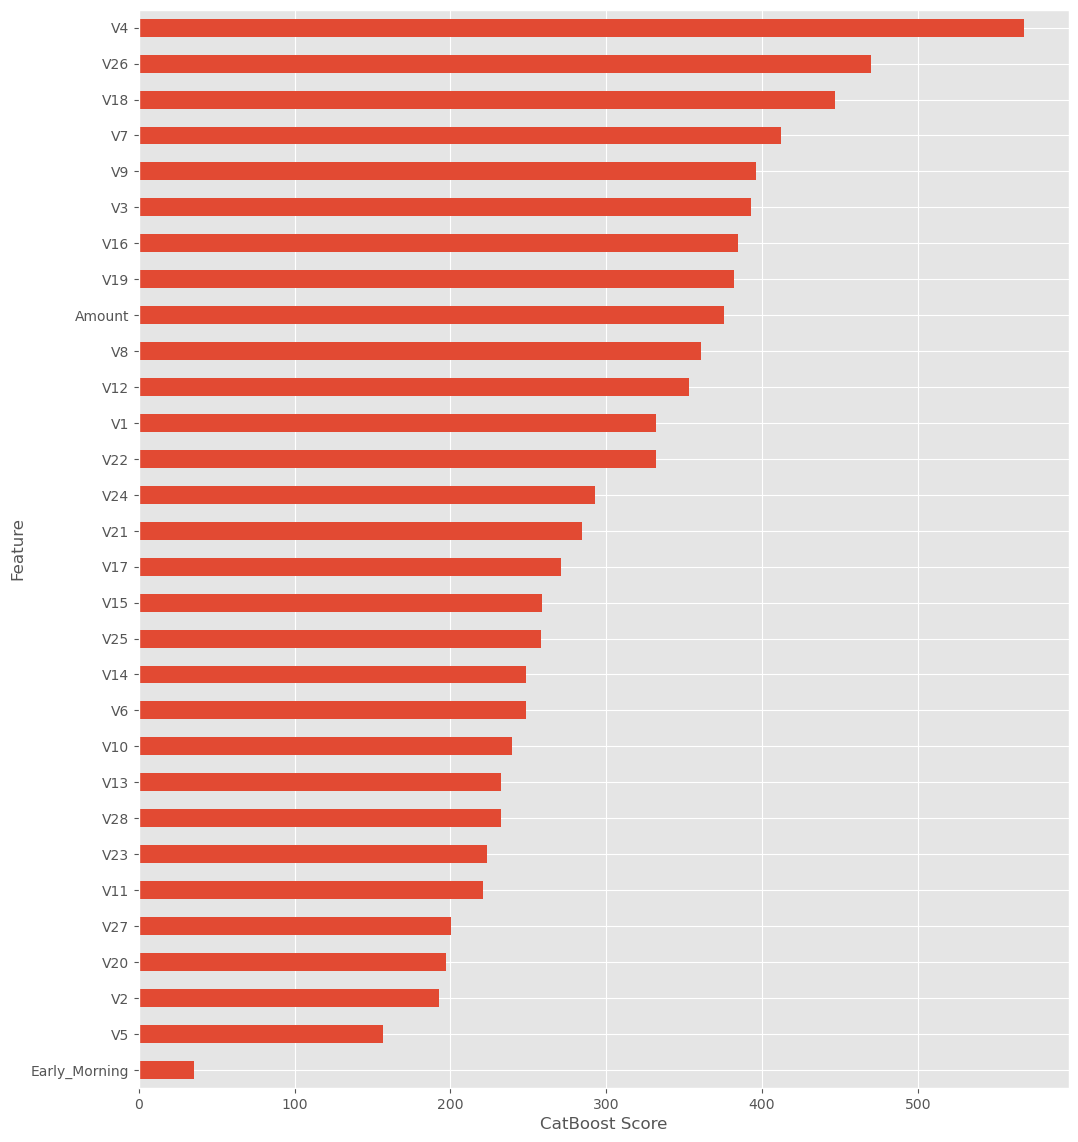

In [38]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('CatBoost Score')
plt.ylabel('Feature')
plt.show();

In [39]:
lgb_preds_test = pd.DataFrame(preds).apply(np.mean, axis = 0)

submission['Class'] = lgb_preds_test
submission.to_csv('lgb_time_FE_1_submission.csv', index = False)

# Time-Series CV

In [34]:
train['Time'] = train['Time'] / 3600
test['Time'] = test['Time'] / 3600

train['Time_Label'] = np.where(((train['Time'] >= 0) & (train['Time'] < 4)), 'Early_Morning',
                               np.where(((train['Time'] >= 4) & (train['Time'] < 10)), 'Morning',
                                       np.where(((train['Time'] >= 10) & (train['Time'] < 16)), 'Afternoon',
                                                np.where(((train['Time'] >= 16) & (train['Time'] < 22)), 'Night',
                                                         np.where(((train['Time'] >= 22) & (train['Time'] < 28)), 'Early_Morning', 'Morning')))))

test['Time_Label'] = np.where(((test['Time'] >= 33) & (test['Time'] < 34)), 'Morning', 
                              np.where(((test['Time'] >= 34) & (test['Time'] < 40)), 'Afternoon', 
                                       np.where(((test['Time'] >= 40) & (test['Time'] < 46)), 'Night', 'Early_Morning')))

train_dummies = pd.get_dummies(train['Time_Label'])
test_dummies = pd.get_dummies(test['Time_Label'])

train = pd.concat([train, train_dummies], axis = 1)
train = train.drop(columns  = ['Time', 'Time_Label'], axis = 1)
# train = train.drop(columns = ['Time', 'Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

test = pd.concat([test, test_dummies], axis = 1)
test = test.drop(columns  = ['Time', 'Time_Label'], axis = 1)
# test = test.drop(columns = ['Time', 'Time_Label', 'Morning', 'Afternoon', 'Night'], axis = 1)

In [35]:
train.head()

id        V1        V2        V3        V4        V5        V6        V7  \
0   0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144  0.110697   
1   1  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866 -1.029289   
2   2  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351  0.948146   
3   3  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829 -0.087826   
4   4  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074 -0.938651   

         V8        V9       V10       V11       V12       V13       V14  \
0 -0.263477  0.742144  0.108782 -1.070243 -0.234910 -1.099360  0.502467   
1  0.050198 -0.109948  0.908773  0.836798 -0.056580 -0.120990 -0.144028   
2 -0.084789 -0.042027 -0.818383 -0.376512 -0.226546 -0.552869 -0.886466   
3 -0.035367  0.885838 -0.007527  0.637441  0.676960 -1.504823  0.554039   
4  0.569239  0.692665 -0.097495  1.338869  1.391399 -0.128167 -0.081836   

        V15       V16       V17       V18       V19       V20       V21  \
0  0.169318  0.065688 -0.306957 -0.323800  0.103348 -0.292969 -0.334701   
1 -0.039582  1.653057 -0.253599 -0.814354  0.716784  0.065717  0.054848   
2 -0.180890  0.230286  0.590579 -0.321590 -0.433959 -0.021375 -0.326725   
3 -0.824356 -0.527267 -0.095838 -0.312519  0.642659 -0.340089 -0.095514   
4  0.100548 -0.338937  0.090864 -0.423645 -0.731939 -0.203628  0.099157   

        V22       V23       V24       V25       V26       V27       V28  \
0 -0.887840  0.336701 -0.110835 -0.291459  0.207733 -0.076576 -0.059577   
1 -0.038367  0.133518 -0.461928 -0.465491 -0.464655 -0.009413 -0.038238   
2 -0.803736  0.154495  0.951233 -0.506919  0.085046  0.224458  0.087356   
3 -0.079792  0.167701 -0.042939  0.000799 -0.096148 -0.057780 -0.073839   
4  0.608908  0.027901 -0.262813  0.257834 -0.252829  0.108338  0.021051   

   Amount  Class  Afternoon  Early_Morning  Morning  Night  
0    1.98      0          0              1        0      0  
1   84.00      0          0              1        0      0  
2    2.69      0          0              1        0      0  
3    1.00      0          0              1        0      0  
4    1.00      0          0              1        0      0

In [36]:
test.head()

id        V1        V2        V3        V4        V5        V6  \
0  219129  2.115519 -0.691809 -1.305514 -0.685655 -0.641265 -0.764784   
1  219130  1.743525 -1.681429 -0.547387 -1.061113 -0.695825  2.458824   
2  219131  2.205568 -1.571445 -0.238965 -1.662517 -1.652324 -0.054701   
3  219132  1.989728 -0.972909 -1.938259 -1.440129 -0.166855 -0.794048   
4  219133 -1.943548 -1.668761  0.363601 -0.977610  2.684779 -2.037681   

         V7        V8        V9       V10       V11       V12       V13  \
0 -0.924262 -0.023030 -0.230126  0.220610  1.058325 -0.723363 -0.619241   
1 -1.632859  1.073529  1.068183  0.483337  0.274519 -0.346514 -0.409519   
2 -1.682064  0.105613 -1.177858  1.626352  0.601148 -0.041610  0.432748   
3  0.252889 -0.399789  2.079398 -1.225592 -0.869368  1.647638  1.138026   
4  0.039709 -0.048895 -0.281749 -0.341879  0.471628  0.637604 -0.592416   

        V14       V15       V16       V17       V18       V19       V20  \
0 -2.243711 -0.271429  2.007845  1.213534  0.282344  0.579121  0.067367   
1 -0.564673 -0.143855  1.334855  0.160901 -0.087356 -0.066264  0.441788   
2 -0.527684 -0.543665  0.043896  0.058472  0.622667  0.010671 -0.366906   
3 -0.258468 -0.361765 -1.253326  0.099479 -0.587702  1.207085 -0.049136   
4  0.331702 -1.451799  0.096467 -0.853439 -0.462060 -0.267098  0.391627   

        V21       V22       V23       V24       V25       V26       V27  \
0  0.241708  0.682524  0.037769 -0.546859 -0.123055 -0.084889  0.004720   
1  0.543278  1.294571  0.309541  3.703925 -0.242579  0.068708  0.002629   
2 -0.131527  0.086623  0.291375  0.739087 -0.543006 -0.297813  0.043699   
3 -0.080115 -0.010732 -0.038550  0.656830  0.343470 -0.627529 -0.024338   
4  0.083389 -0.306918  0.247822 -0.391799 -0.790716 -0.025706  0.330758   

        V28  Amount  Afternoon  Early_Morning  Morning  Night  
0 -0.021944   29.95          0              0        1      0  
1  0.064690  163.50          0              0        1      0  
2 -0.037855   16.00          0              0        1      0  
3 -0.036143  120.98          0              0        1      0  
4  0.335537    1.98          0              0        1      0

In [40]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
# test = test.drop(columns = 'id', axis = 1)

XGB_cv_scores, XGB_imp = list(), list()
preds = list()

## Running 5 times CV
# for i in range(5):

skf = TimeSeriesSplit(n_splits = 4)
# skf = StratifiedKFold(n_splits = 5, shuffle = False)
    
for train_ix, test_ix in skf.split(X, Y):
        
    ## Splitting the data 
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
    ## Building RF model
    XGB_md = XGBClassifier(tree_method = 'hist',
                           colsample_bytree = 0.7, 
                           gamma = 0.8, 
                           learning_rate = 0.01, 
                           max_depth = 7, 
                           min_child_weight = 10, 
                           n_estimators = 1000, 
                           subsample = 0.7).fit(X_train, Y_train)
    XGB_imp.append(XGB_md.feature_importances_)
        
    ## Predicting on X_test and test
    XGB_pred_1 = XGB_md.predict_proba(X_test)[:, 1]
    XGB_pred_2 = XGB_md.predict_proba(test)[:, 1]
        
    ## Computing roc-auc score
    XGB_cv_scores.append(roc_auc_score(Y_test, XGB_pred_1))
    preds.append(XGB_pred_2)

XGB_cv_score = np.mean(XGB_cv_scores)    
print('The average roc-auc score over 5-folds (run 5 times) is:', XGB_cv_score)

The average roc-auc score over 5-folds (run 5 times) is: 0.8055723485883632


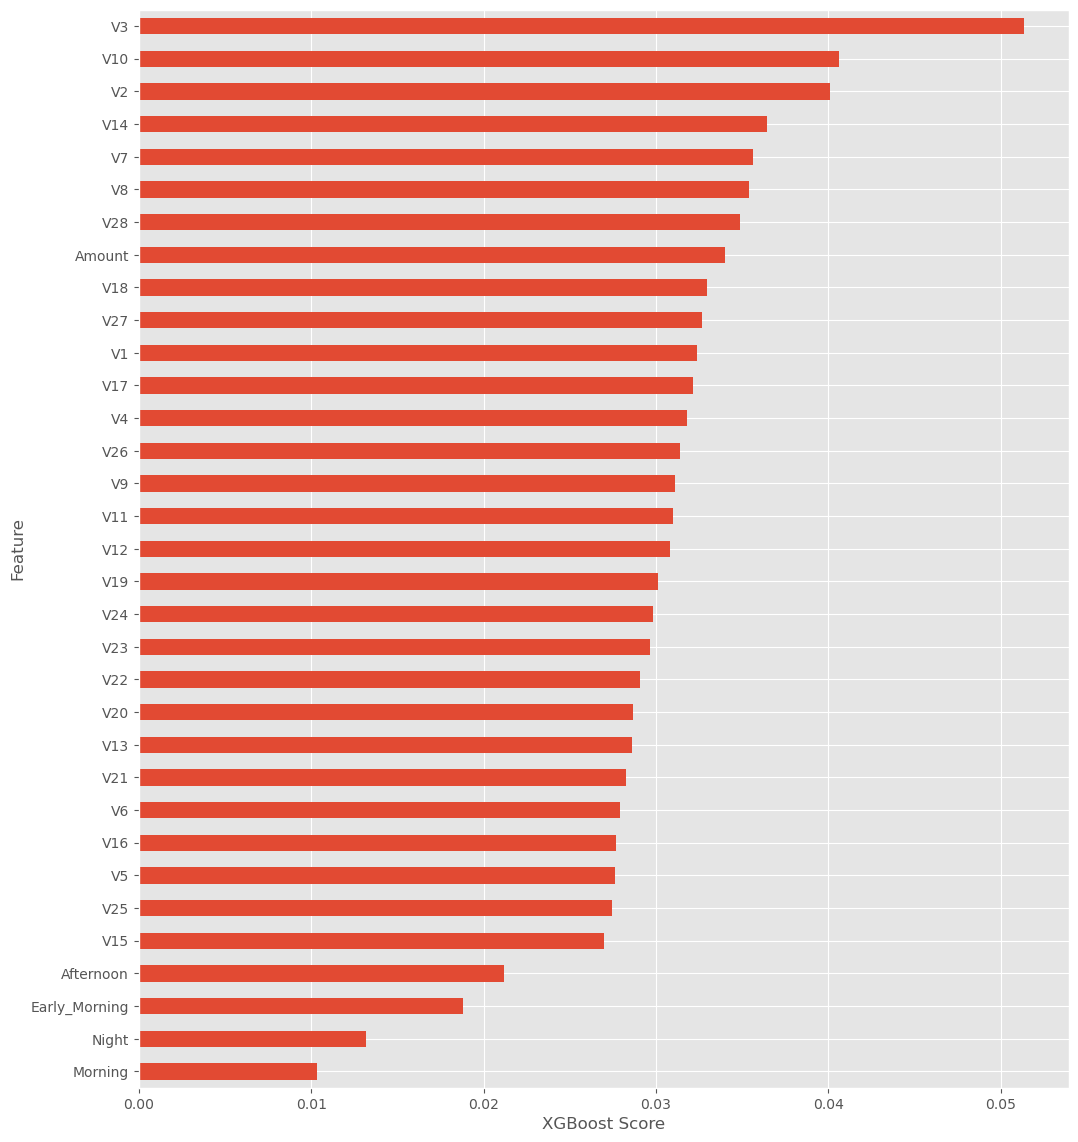

In [41]:
plt.figure(figsize = (12, 14))
pd.DataFrame(XGB_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('XGBoost Score')
plt.ylabel('Feature')
plt.show();

In [42]:
X.head()

V1        V2        V3        V4        V5        V6        V7  \
0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144  0.110697   
1  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866 -1.029289   
2  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351  0.948146   
3  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829 -0.087826   
4  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074 -0.938651   

         V8        V9       V10       V11       V12       V13       V14  \
0 -0.263477  0.742144  0.108782 -1.070243 -0.234910 -1.099360  0.502467   
1  0.050198 -0.109948  0.908773  0.836798 -0.056580 -0.120990 -0.144028   
2 -0.084789 -0.042027 -0.818383 -0.376512 -0.226546 -0.552869 -0.886466   
3 -0.035367  0.885838 -0.007527  0.637441  0.676960 -1.504823  0.554039   
4  0.569239  0.692665 -0.097495  1.338869  1.391399 -0.128167 -0.081836   

        V15       V16       V17       V18       V19       V20       V21  \
0  0.169318  0.065688 -0.306957 -0.323800  0.103348 -0.292969 -0.334701   
1 -0.039582  1.653057 -0.253599 -0.814354  0.716784  0.065717  0.054848   
2 -0.180890  0.230286  0.590579 -0.321590 -0.433959 -0.021375 -0.326725   
3 -0.824356 -0.527267 -0.095838 -0.312519  0.642659 -0.340089 -0.095514   
4  0.100548 -0.338937  0.090864 -0.423645 -0.731939 -0.203628  0.099157   

        V22       V23       V24       V25       V26       V27       V28  \
0 -0.887840  0.336701 -0.110835 -0.291459  0.207733 -0.076576 -0.059577   
1 -0.038367  0.133518 -0.461928 -0.465491 -0.464655 -0.009413 -0.038238   
2 -0.803736  0.154495  0.951233 -0.506919  0.085046  0.224458  0.087356   
3 -0.079792  0.167701 -0.042939  0.000799 -0.096148 -0.057780 -0.073839   
4  0.608908  0.027901 -0.262813  0.257834 -0.252829  0.108338  0.021051   

   Amount  Afternoon  Early_Morning  Morning  Night  
0    1.98          0              1        0      0  
1   84.00          0              1        0      0  
2    2.69          0              1        0      0  
3    1.00          0              1        0      0  
4    1.00          0              1        0      0

In [43]:
lgb_cv_scores, lgb_imp = list(), list()
preds = list()

## Running 5 times CV
# for i in range(5):
    
skf = TimeSeriesSplit(n_splits = 4)    
#     skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    
for train_ix, test_ix in skf.split(X, Y):
        
    ## Splitting the data 
    X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]
    Y_train, Y_test = Y.iloc[train_ix], Y.iloc[test_ix]
                
    ## Building RF model
    lgb_md = LGBMClassifier(n_estimators = 1000,
                            max_depth = 17,
                            learning_rate = 0.01,
                            num_leaves = 10,
                            lambda_l1 = 3,
                            lambda_l2 = 3,
                            bagging_fraction = 0.7,
                            feature_fraction = 0.7).fit(X_train, Y_train)
    lgb_imp.append(lgb_md.feature_importances_)
        
    ## Predicting on X_test and test
    lgb_pred_1 = lgb_md.predict_proba(X_test)[:, 1]
    lgb_pred_2 = lgb_md.predict_proba(test)[:, 1]
        
    ## Computing roc-auc score
    lgb_cv_scores.append(roc_auc_score(Y_test, lgb_pred_1))
    preds.append(lgb_pred_2)

lgb_cv_score = np.mean(lgb_cv_scores)    
print('The average oof roc-auc score over 5-folds (run 5 times) is:', lgb_cv_score)

[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=3, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3
[LightGBM] [Warning] 

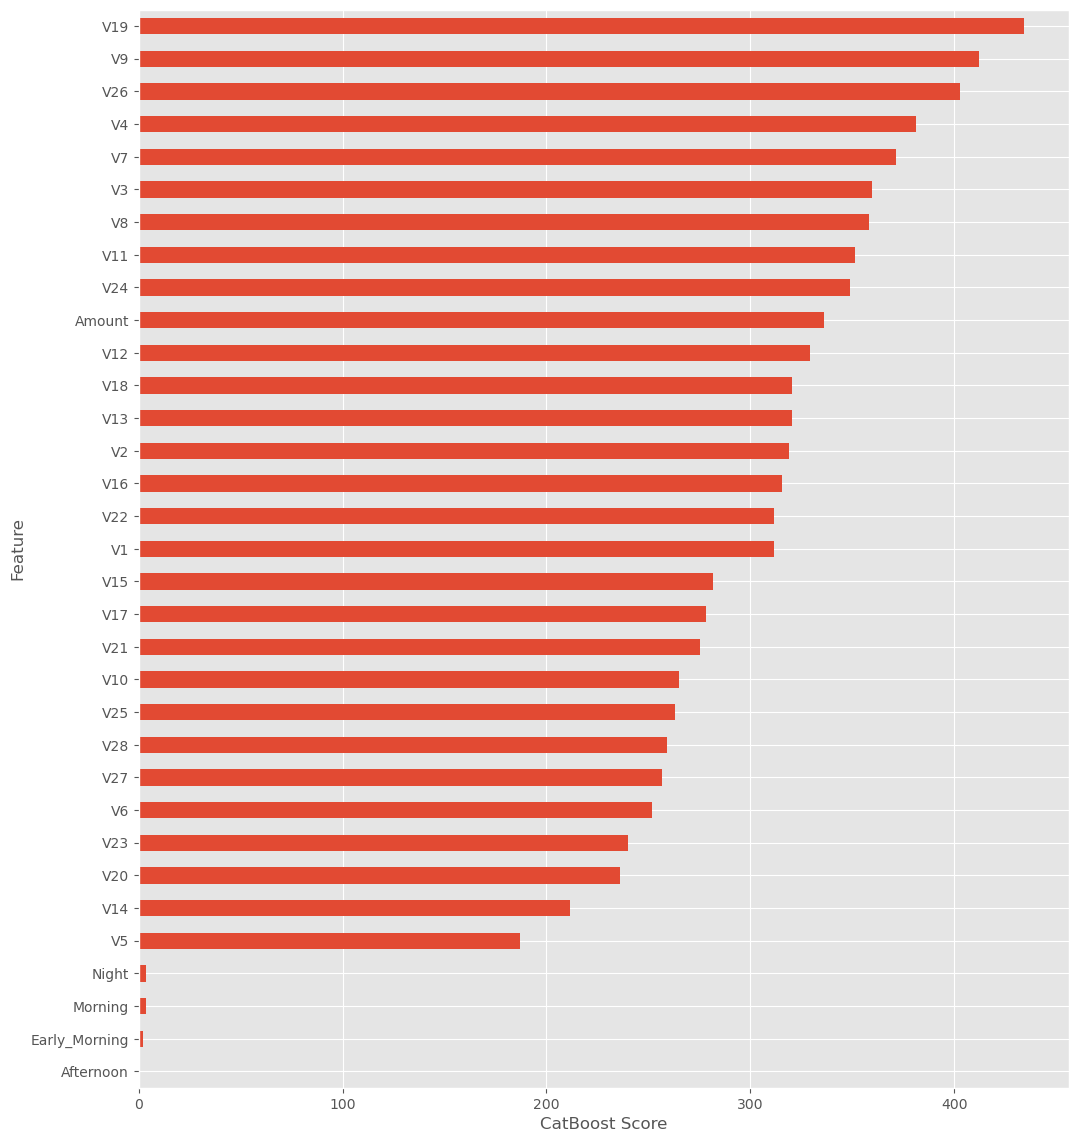

In [44]:
plt.figure(figsize = (12, 14))
pd.DataFrame(lgb_imp, columns = X.columns).apply(np.mean, axis = 0).sort_values().plot(kind = 'barh');
plt.xlabel('CatBoost Score')
plt.ylabel('Feature')
plt.show();

In [72]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns

from scipy.stats import rankdata
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import lightgbm as lg
import optuna as op

from optuna.integration import LightGBMPruningCallback


s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-4/sample_submission.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
test = pd.read_csv(file_content_stream_2)
submission = pd.read_csv(file_content_stream_3)

In [73]:
train.head()

id  Time        V1        V2        V3        V4        V5        V6  \
0   0   0.0  2.074329 -0.129425 -1.137418  0.412846 -0.192638 -1.210144   
1   1   0.0  1.998827 -1.250891 -0.520969 -0.894539 -1.122528 -0.270866   
2   2   0.0  0.091535  1.004517 -0.223445 -0.435249  0.667548 -0.988351   
3   3   0.0  1.979649 -0.184949 -1.064206  0.120125 -0.215238 -0.648829   
4   4   0.0  1.025898 -0.171827  1.203717  1.243900 -0.636572  1.099074   

         V7        V8        V9       V10       V11       V12       V13  \
0  0.110697 -0.263477  0.742144  0.108782 -1.070243 -0.234910 -1.099360   
1 -1.029289  0.050198 -0.109948  0.908773  0.836798 -0.056580 -0.120990   
2  0.948146 -0.084789 -0.042027 -0.818383 -0.376512 -0.226546 -0.552869   
3 -0.087826 -0.035367  0.885838 -0.007527  0.637441  0.676960 -1.504823   
4 -0.938651  0.569239  0.692665 -0.097495  1.338869  1.391399 -0.128167   

        V14       V15       V16       V17       V18       V19       V20  \
0  0.502467  0.169318  0.065688 -0.306957 -0.323800  0.103348 -0.292969   
1 -0.144028 -0.039582  1.653057 -0.253599 -0.814354  0.716784  0.065717   
2 -0.886466 -0.180890  0.230286  0.590579 -0.321590 -0.433959 -0.021375   
3  0.554039 -0.824356 -0.527267 -0.095838 -0.312519  0.642659 -0.340089   
4 -0.081836  0.100548 -0.338937  0.090864 -0.423645 -0.731939 -0.203628   

        V21       V22       V23       V24       V25       V26       V27  \
0 -0.334701 -0.887840  0.336701 -0.110835 -0.291459  0.207733 -0.076576   
1  0.054848 -0.038367  0.133518 -0.461928 -0.465491 -0.464655 -0.009413   
2 -0.326725 -0.803736  0.154495  0.951233 -0.506919  0.085046  0.224458   
3 -0.095514 -0.079792  0.167701 -0.042939  0.000799 -0.096148 -0.057780   
4  0.099157  0.608908  0.027901 -0.262813  0.257834 -0.252829  0.108338   

        V28  Amount  Class  
0 -0.059577    1.98      0  
1 -0.038238   84.00      0  
2  0.087356    2.69      0  
3 -0.073839    1.00      0  
4  0.021051    1.00      0

In [74]:
X = train.drop(columns = ['id', 'Class'], axis = 1)
Y = train['Class']
test = test.drop(columns = 'id', axis = 1)


# rskf = RepeatedStratifiedKFold(n_repeats = 5, n_splits = 5, random_state = 1)

def objective(trial):
    
    scores = []
    counter = 1 
        
    params = {
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        'boosting_type': 'gbdt',
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-5, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-4, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 75),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.35, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 8),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 25),
    }
    
    lgb_model = LGBMClassifier(**params)
    rskf = RepeatedStratifiedKFold(n_repeats = 5, n_splits = 5, random_state=1)
    
    for i, (train_idx, test_index) in enumerate(rskf.split(X, Y)):
        
        x_train, x_valid  = X.iloc[train_idx], X.iloc[test_index]
        y_train, y_valid  = Y.iloc[train_idx], Y.iloc[test_index]
        
        # Fit and train xgboost
        lgb_model.fit(x_train, y_train,
                      eval_set =[(x_valid, y_valid)],
                    verbose=100,
              eval_metric=['auc'],
              early_stopping_rounds=100,
              callbacks=[
                LightGBMPruningCallback(trial, "auc")
            ])
        
        pred_val = lgb_model.predict(x_valid)
        #predictions = [round(value) for value in pred_val]
        score = roc_auc_score(y_valid, pred_val)
        print(f"Fold {counter} Lightgbm {score}")
        scores.append(score)
        
    return np.mean(scores)

In [75]:
pruner = op.pruners.MedianPruner(n_startup_trials=35, n_warmup_steps=50)
sampler = op.samplers.TPESampler(multivariate=True, n_startup_trials=35)
study = op.create_study(direction="maximize", sampler=sampler, pruner=pruner)

study.optimize(objective, n_trials=10)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:282: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-01-25 12:18:15,288] A new study created in memory with name: no-name-1d6b5d4f-af11-4102-a00b-83cf3ffa530c
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _l

[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336
[100]	valid_0's auc: 0.68254
Fold 1 Lightgbm 0.5158088142282491


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.704928
Fold 1 Lightgbm 0.5051933829067181


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.733854
Fold 1 Lightgbm 0.505239116008337


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.711908
Fold 1 Lightgbm 0.4998971005213574


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.669103
Fold 1 Lightgbm 0.5106383554179956


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.676111
Fold 1 Lightgbm 0.5052505492837418


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.67942
Fold 1 Lightgbm 0.4997484679410958


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.667997
Fold 1 Lightgbm 0.5052048161821229


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.744103
Fold 1 Lightgbm 0.4999657001737858


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.726421
Fold 1 Lightgbm 0.49991996707216685


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.681255
Fold 1 Lightgbm 0.5051819496313135


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.711591
Fold 1 Lightgbm 0.4998513674197384


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.721781
Fold 1 Lightgbm 0.49993140034757155
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.725293
Fold 1 Lightgbm 0.505239116008337
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.710343
Fold 1 Lightgbm 0.505307744433593


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.669083
Fold 1 Lightgbm 0.5051362165296944


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.652772
Fold 1 Lightgbm 0.5104896652920788
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.74106
Fold 1 Lightgbm 0.49983993414433364


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.696945
Fold 1 Lightgbm 0.5051819496313135
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.714094
Fold 1 Lightgbm 0.5160261327794219
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.675385
Fold 1 Lightgbm 0.5051247832542897
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.649823
Fold 1 Lightgbm 0.5051247832542897
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.717114
Fold 1 Lightgbm 0.5211050966136098
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.693328
Fold 1 Lightgbm 0.5104210656396504
[LightGBM] [Warning] feature_fraction is set=0.45529157618245497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45529157618245497
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.0019678019329389595, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019678019329389595
[LightGBM] [Warning] bagging_fraction is set=0.9824986315731372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9824986315731372
[LightGBM] [Warning] lambda_l1 is set=0.0008460671690315336, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008460671690315336


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.708968
Fold 1 Lightgbm 0.5053649108106167


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083
[100]	valid_0's auc: 0.83045
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [War

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.8152
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.826913
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.782645
Fold 1 Lightgbm 0.49998856672459524
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.797003
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.834755
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.823601
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.833462
Fold 1 Lightgbm 0.5053191489361702
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.795381
Fold 1 Lightgbm 0.5053191489361702
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.80927
Fold 1 Lightgbm 0.49998856672459524
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.805477
Fold 1 Lightgbm 0.49998856672459524
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.82585
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.818096
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.801517
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.804988
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.819119
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.788196
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.820656
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.818681
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.844144
Fold 1 Lightgbm 0.49998856672459524


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.814922
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.777344
Fold 1 Lightgbm 0.5053077156607655
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.774627
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.819425
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.5735218477668163, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5735218477668163
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=2.7813647700068285, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7813647700068285
[LightGBM] [Warning] bagging_fraction is set=0.5039521539894363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5039521539894363
[LightGBM] [Warning] lambda_l1 is set=8.206864115668083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.206864115668083


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.841616
Fold 1 Lightgbm 0.5


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907
[100]	valid_0's auc: 0.63985
Fold 1 Lightgbm 0.5207163652498487
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: baggi

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.599173
Fold 1 Lightgbm 0.5262184465924947
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.535882
Fold 1 Lightgbm 0.5257382490254957
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.586891
Fold 1 Lightgbm 0.5153400499366548
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.59905
Fold 1 Lightgbm 0.5155459352124229
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.679034
Fold 1 Lightgbm 0.5045988525856717
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.526893
Fold 1 Lightgbm 0.5153171833858453
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.541955
Fold 1 Lightgbm 0.5102838663347935
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.625484
Fold 1 Lightgbm 0.520659198872825
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.595729
Fold 1 Lightgbm 0.510272490605044
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.614222
Fold 1 Lightgbm 0.5153972163136784
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.665507
Fold 1 Lightgbm 0.5209107309317292
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.545051
Fold 1 Lightgbm 0.5473349764815092
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.610673
Fold 1 Lightgbm 0.5101009339283177
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.62425
Fold 1 Lightgbm 0.5208994127476348
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.571502
Fold 1 Lightgbm 0.5313432298467844
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.537844
Fold 1 Lightgbm 0.5207163652498487
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.629867
Fold 1 Lightgbm 0.49938260312814414
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.590145
Fold 1 Lightgbm 0.5099408680726514
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.621353
Fold 1 Lightgbm 0.5207507801673733
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.603511
Fold 1 Lightgbm 0.5260926805630425
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.590994
Fold 1 Lightgbm 0.515591581995559
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.613867
Fold 1 Lightgbm 0.5259554812581857
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.537036
Fold 1 Lightgbm 0.5206934986990392
[LightGBM] [Warning] feature_fraction is set=0.6696428108327377, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6696428108327377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.00015462596921850423, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015462596921850423
[LightGBM] [Warning] bagging_fraction is set=0.8838780584994197, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8838780584994197
[LightGBM] [Warning] lambda_l1 is set=0.2653774636634907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2653774636634907


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.579239
Fold 1 Lightgbm 0.537131344484342
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.442294
Fold 1 Lightgbm 0.5135678922489204
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.521591
Fold 1 Lightgbm 0.5208676737030773


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.557117
Fold 1 Lightgbm 0.5108010396009739
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.606466
Fold 1 Lightgbm 0.5152371504580122


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.481817
Fold 1 Lightgbm 0.5204763815576595


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.479785
Fold 1 Lightgbm 0.5143567882518474
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.509009
Fold 1 Lightgbm 0.5304971674668338
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.594187
Fold 1 Lightgbm 0.5320319022440357


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.526309
Fold 1 Lightgbm 0.5237945922066902


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.572372
Fold 1 Lightgbm 0.5095178944283313


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.620444
Fold 1 Lightgbm 0.5096893360137472


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.462797
Fold 1 Lightgbm 0.5357362834751708


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.491561
Fold 1 Lightgbm 0.5190814068669711
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.541393
Fold 1 Lightgbm 0.5192986390996612


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.47211
Fold 1 Lightgbm 0.5302115082186809


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.552203
Fold 1 Lightgbm 0.5216908695322184


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.673441
Fold 1 Lightgbm 0.5255781831698293
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.555449
Fold 1 Lightgbm 0.5146883532385846


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.505124
Fold 1 Lightgbm 0.5299483702474063
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.558246
Fold 1 Lightgbm 0.5371569156809463


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.498165
Fold 1 Lightgbm 0.5272272507010788


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.405054
Fold 1 Lightgbm 0.5190699735915665
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.483342
Fold 1 Lightgbm 0.5132591938129925
[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.56889
Fold 1 Lightgbm 0.5216108366043852


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6898076644429672, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6898076644429672
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.0021326797891699223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021326797891699223
[LightGBM] [Warning] bagging_fraction is set=0.7612737474514506, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7612737474514506
[LightGBM] [Warning] lambda_l1 is set=4.758929724337231e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.758929724337231e-05


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.477135
Fold 1 Lightgbm 0.523931935375685


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857
[100]	valid_0's auc: 0.778422
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Wa

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.771581
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.803485
Fold 1 Lightgbm 0.49998856672459524
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.794597
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.779477
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.828698
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.791433
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.785838
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.790187
Fold 1 Lightgbm 0.49998856672459524
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.749431
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.804755
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.775092
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.782485
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.792869
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.806944
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.768587
Fold 1 Lightgbm 0.49997713344919054
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.743817
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.800023
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.783374
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.832764
Fold 1 Lightgbm 0.5


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.784263
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.746428
Fold 1 Lightgbm 0.49998856672459524
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.769375
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.804067
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.4228983231924204, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4228983231924204
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.995674466867407, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.995674466867407
[LightGBM] [Warning] bagging_fraction is set=0.6682434881293002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6682434881293002
[LightGBM] [Warning] lambda_l1 is set=0.7309081332182857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7309081332182857


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.820589
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.642813
Fold 1 Lightgbm 0.5464774808261539
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.680837
Fold 1 Lightgbm 0.5305200340176432
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.691416
Fold 1 Lightgbm 0.5197216702896366
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.643365
Fold 1 Lightgbm 0.5357362834751708
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.670836
Fold 1 Lightgbm 0.5254982941061341
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.661715
Fold 1 Lightgbm 0.5570814788722801
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.629793
Fold 1 Lightgbm 0.5198360030436838
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.599279
Fold 1 Lightgbm 0.5142081556715857
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.733712
Fold 1 Lightgbm 0.5102724330593889
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.645713
Fold 1 Lightgbm 0.5199047177874226
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.622484
Fold 1 Lightgbm 0.525109418878235
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.577153
Fold 1 Lightgbm 0.5251437187044493
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.697317
Fold 1 Lightgbm 0.5155458488939401
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.64993
Fold 1 Lightgbm 0.535907782606242
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.677634
Fold 1 Lightgbm 0.541135695521795
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.650886
Fold 1 Lightgbm 0.5142767553240142
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.626366
Fold 1 Lightgbm 0.5040157555400302
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.704412
Fold 1 Lightgbm 0.5409868327589126
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.647485
Fold 1 Lightgbm 0.5356105174457187
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.540993
Fold 1 Lightgbm 0.5091291630645702
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.58562
Fold 1 Lightgbm 0.5299712367982159
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.680193
Fold 1 Lightgbm 0.5153857830382738
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.66967
Fold 1 Lightgbm 0.5249950861241877
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.619631
Fold 1 Lightgbm 0.5146654866877752
[LightGBM] [Warning] feature_fraction is set=0.6701713345132551, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6701713345132551
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l2 is set=0.00011886823826071126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011886823826071126
[LightGBM] [Warning] bagging_fraction is set=0.7780888958598489, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7780888958598489
[LightGBM] [Warning] lambda_l1 is set=0.6663508505259288, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6663508505259288


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.642733
Fold 1 Lightgbm 0.5302229414940857
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091
[100]	valid_0's auc: 0.779442
Fold 1 Lightgbm 0.4999428336229763
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.760239
Fold 1 Lightgbm 0.4999657001737858
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.810985
Fold 1 Lightgbm 0.49997713344919054
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.751059
Fold 1 Lightgbm 0.5105811314953167
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.746981
Fold 1 Lightgbm 0.49997713344919054
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.829951
Fold 1 Lightgbm 0.4999657001737858
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.7637
Fold 1 Lightgbm 0.5052734158345513
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.738792
Fold 1 Lightgbm 0.49998856672459524
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.777074
Fold 1 Lightgbm 0.5106154313215309
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.759286
Fold 1 Lightgbm 0.505353477535212


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.761559
Fold 1 Lightgbm 0.5053077156607655
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.772751
Fold 1 Lightgbm 0.5211279631644193
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.791226
Fold 1 Lightgbm 0.5052848491099561
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.798441
Fold 1 Lightgbm 0.4999542668983811
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.763238
Fold 1 Lightgbm 0.5053191777089978
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.780676
Fold 1 Lightgbm 0.49997713344919054
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.715932
Fold 1 Lightgbm 0.4999542668983811
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.781587
Fold 1 Lightgbm 0.4999657001737858
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.761566
Fold 1 Lightgbm 0.49997713344919054
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.819879
Fold 1 Lightgbm 0.5107298216212335
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.778462
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.73534
Fold 1 Lightgbm 0.515854547329868
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.763284
Fold 1 Lightgbm 0.4999085337967621
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.776816
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.44335140553931557, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44335140553931557
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l2 is set=0.23921057239807722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23921057239807722
[LightGBM] [Warning] bagging_fraction is set=0.579623406927144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.579623406927144
[LightGBM] [Warning] lambda_l1 is set=0.3326407816287091, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3326407816287091


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.826837
Fold 1 Lightgbm 0.4999542668983811
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171
[100]	valid_0's auc: 0.792882
Fold 1 Lightgbm 0.5105353983936978
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is s

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.765251
Fold 1 Lightgbm 0.5157630811266302
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.810636
Fold 1 Lightgbm 0.4999657001737858


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.760692
Fold 1 Lightgbm 0.5105582649445072
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.780603
Fold 1 Lightgbm 0.5052848778827836


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.836737
Fold 1 Lightgbm 0.510523965118293


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.77727
Fold 1 Lightgbm 0.505239116008337
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.768088
Fold 1 Lightgbm 0.5052276827329323
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.776123
Fold 1 Lightgbm 0.4999542668983811


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.764642
Fold 1 Lightgbm 0.5158546336483508
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.790748
Fold 1 Lightgbm 0.5051819496313135
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.766441
Fold 1 Lightgbm 0.5051933829067181
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.755843
Fold 1 Lightgbm 0.4999428336229763
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.762265
Fold 1 Lightgbm 0.5105468316691025
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.787335
Fold 1 Lightgbm 0.5105926223163767
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.777099
Fold 1 Lightgbm 0.5052048161821229


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.753349
Fold 1 Lightgbm 0.5157745144020348
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.772512
Fold 1 Lightgbm 0.5052505492837418
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.767737
Fold 1 Lightgbm 0.5051590830805038
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.794373
Fold 1 Lightgbm 0.5213453104884196
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.793606
Fold 1 Lightgbm 0.5210021971349671
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.750838
Fold 1 Lightgbm 0.5264013789989704
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.728252
Fold 1 Lightgbm 0.5052048161821229
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.792549
Fold 1 Lightgbm 0.5105353983936978
[LightGBM] [Warning] feature_fraction is set=0.5578973285633028, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5578973285633028
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l2 is set=0.04584490603829953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04584490603829953
[LightGBM] [Warning] bagging_fraction is set=0.8396929178896739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8396929178896739
[LightGBM] [Warning] lambda_l1 is set=0.8377921352436171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8377921352436171


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.797682
Fold 1 Lightgbm 0.5106612219688051
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.691716
Fold 1 Lightgbm 0.5262413131433041
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.708317
Fold 1 Lightgbm 0.510260999783984
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.742319
Fold 1 Lightgbm 0.5366623787829546
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.733761
Fold 1 Lightgbm 0.5048389513691712
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.675687
Fold 1 Lightgbm 0.5209680124000633
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.744702
Fold 1 Lightgbm 0.5101123672037224
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.670095
Fold 1 Lightgbm 0.5101009339283177
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.675962
Fold 1 Lightgbm 0.5261841467662804
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.71836
Fold 1 Lightgbm 0.5149170187466795
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.689044
Fold 1 Lightgbm 0.5209108460230396
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.72913
Fold 1 Lightgbm 0.5209335974825388
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.744075
Fold 1 Lightgbm 0.5312860634697607
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.70567
Fold 1 Lightgbm 0.5048046515429571
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.668238
Fold 1 Lightgbm 0.5099408680726514
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.674336
Fold 1 Lightgbm 0.5262643235582517
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.741348
Fold 1 Lightgbm 0.5207392318006582
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.64027
Fold 1 Lightgbm 0.5205677326695871
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.65209
Fold 1 Lightgbm 0.5049761506740281
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.697044
Fold 1 Lightgbm 0.5260583807368283
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.709135
Fold 1 Lightgbm 0.5211052117049202
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.686717
Fold 1 Lightgbm 0.5208078314530866
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.643176
Fold 1 Lightgbm 0.5206477655974203
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.655034
Fold 1 Lightgbm 0.5205105662925634
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.680898
Fold 1 Lightgbm 0.5366623787829546
[LightGBM] [Warning] feature_fraction is set=0.6555707246812152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6555707246812152
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.000401770027309183, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000401770027309183
[LightGBM] [Warning] bagging_fraction is set=0.5004154358733844, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5004154358733844
[LightGBM] [Warning] lambda_l1 is set=0.08754107294643232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.08754107294643232


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.721755
Fold 1 Lightgbm 0.5212881441113959
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's auc: 0.749715
Fold 1 Lightgbm 0.510523965118293
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.795758
Fold 1 Lightgbm 0.4999542668983811


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.78639
Fold 1 Lightgbm 0.5052734158345513


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.776801
Fold 1 Lightgbm 0.5052962823853608


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.766988
Fold 1 Lightgbm 0.5052848778827836
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.79626
Fold 1 Lightgbm 0.5052734158345513
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.754251
Fold 1 Lightgbm 0.4999542668983811
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.727866
Fold 1 Lightgbm 0.5158202475036537
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.789427
Fold 1 Lightgbm 0.5106154313215309


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.746532
Fold 1 Lightgbm 0.4998971005213574
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.765147
Fold 1 Lightgbm 0.4999542668983811
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.728729
Fold 1 Lightgbm 0.5158659806052727
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.777276
Fold 1 Lightgbm 0.49997713344919054
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.767945
Fold 1 Lightgbm 0.49998856672459524


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.782266
Fold 1 Lightgbm 0.49991996707216685


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.756111
Fold 1 Lightgbm 0.5052734158345513


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.705566
Fold 1 Lightgbm 0.49987423397054787
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.752437
Fold 1 Lightgbm 0.5105582649445072
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.745817
Fold 1 Lightgbm 0.49993140034757155
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.794879
Fold 1 Lightgbm 0.5
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.781359
Fold 1 Lightgbm 0.49991996707216685
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.

[100]	valid_0's auc: 0.733792
Fold 1 Lightgbm 0.5052048161821229
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.741856
Fold 1 Lightgbm 0.5106154313215309
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.75917
Fold 1 Lightgbm 0.5105925647707215
[LightGBM] [Warning] feature_fraction is set=0.6744550675208236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744550675208236
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l2 is set=0.10778451734899641, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10778451734899641
[LightGBM] [Warning] bagging_fraction is set=0.5045371506212859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5045371506212859
[LightGBM] [Warning] lambda_l1 is set=0.05666150111838005, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05666150111838005


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/optuna/trial/_trial.py:490: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/home/ec2-

[100]	valid_0's auc: 0.805726
Fold 1 Lightgbm 0.5052848778827836


In [76]:
print(f"\tBest value (auc): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (auc): 0.52565
	Best params:
		lambda_l1: 0.6663508505259288
		lambda_l2: 0.00011886823826071126
		max_depth: 44
		num_leaves: 112
		feature_fraction: 0.6701713345132551
		bagging_fraction: 0.7780888958598489
		bagging_freq: 6
		min_child_samples: 16
